In [1]:
import ast
import os
#from nn_utils import TrainingHistory
from keras.layers import Dense, Embedding, Input
from keras.layers import GRU, Dropout, MaxPooling1D, Conv1D, Flatten
from keras.models import Model
import numpy as np
import itertools
from keras.utils import np_utils
from sklearn.metrics import (classification_report, 
                             precision_recall_fscore_support, 
                             accuracy_score)
import numpy as np
from keras.preprocessing import text, sequence

# Model parameters
MAX_FEATURES = 183312# YOUR CODE HERE
MAX_TEXT_LENGTH = 1024# YOUR CODE HERE
EMBED_SIZE  = 100# YOUR CODE HERE
BATCH_SIZE = 16
EPOCHS = 2
VALIDATION_SPLIT = 0.1

Using TensorFlow backend.


Nous définissons un modèle de classification de texte avec une couche de Conv1D et une couche de Dense. Nous pouvons utiliser les vecteurs de mots pré-appris. Le modèle est basé sur le [TP de M. Kermorvant](https://gitlab.com/kermorvant/nlp-labs).

In [14]:
def get_train_test(train_raw_text, test_raw_text):
    
    tokenizer = text.Tokenizer(num_words=MAX_FEATURES)

    tokenizer.fit_on_texts(list(train_raw_text))
    train_tokenized = tokenizer.texts_to_sequences(train_raw_text)
    test_tokenized = tokenizer.texts_to_sequences(test_raw_text)
    return sequence.pad_sequences(train_tokenized, maxlen=MAX_TEXT_LENGTH), \
           sequence.pad_sequences(test_tokenized, maxlen=MAX_TEXT_LENGTH)



def get_model(embedding_matrix):

    inp = Input(shape=(MAX_TEXT_LENGTH,))
    #modification here
    model = Embedding(len(word_index) + 1,
                      EMBED_SIZE,
                      weights=[embedding_matrix],
                      input_length=MAX_TEXT_LENGTH,
                      trainable=False)(inp)
    
    model = Dropout(0.5)(model)
    model = Conv1D(filters=32, kernel_size=2, padding='same', activation='relu')(model)
    model = MaxPooling1D(pool_size=2)(model)
    model = Flatten()(model)
    model = Dense(11, activation="softmax")(model)
    model = Model(inputs=inp, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model


def train_fit_predict(model, x_train, x_test, y_train):
    
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS, verbose=1)

    return model.predict(x_test)


Nous lisons le jeu de données d'apprentissage et de test.

In [20]:
x_train = []
y_train = []
x_test = []
y_test = []
with open('datasets/news_less_category.txt', 'r') as f:
    for line in f:
        temp = line.split('__label__')
        x_train.append(temp[0])
        y_train.append(temp[1])
with open('datasets/news_fasttext_test.txt', 'r') as f:
    for line in f:
        temp = line.split('__label__')
        x_test.append(temp[0])
        y_test.append(temp[1])

Maintenant nous allons lire les vecteurs de mots pré-appris. Cette partie est basé sur le [tutoriel de Keras](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html) 

In [4]:
embeddings_index = {}
with open('word2vec_skip.txt', 'r') as f:
    first_line = f.readline()
    print(first_line)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


print('Found %s word vectors.' % len(embeddings_index))

183311 100

Found 183311 word vectors.


In [6]:
tokenizer = text.Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Nous allons d'abord tokenizer les données au format pour le réseau de neurones

In [21]:
# Get the list of different classes
CLASSES_LIST = np.unique(y_train)
n_out = len(CLASSES_LIST)
print(CLASSES_LIST)

# Convert clas string to index
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(CLASSES_LIST)
y_train = le.transform(y_train) 
y_test = le.transform(y_test) 
train_y_cat = np_utils.to_categorical(y_train, n_out)

# get the textual data in the correct format for NN
x_vec_train, x_vec_test = get_train_test(x_train, x_test)
print(len(x_vec_train), len(x_vec_test))

['affairs\n' 'economic\n' 'edu\n' 'ent\n' 'fashion\n' 'game\n' 'home\n'
 'house\n' 'science\n' 'sports\n' 'stock\n']
109989 103369


Nous entraînons le modèle.

In [22]:
# define the NN topology
model = get_model(embedding_matrix)

# Define training procedure
#history = TrainingHistory(x_vec_test, y_test, CLASSES_LIST)

# Train and predict
y_predicted = train_fit_predict(model, x_vec_train, x_vec_test, train_y_cat).argmax(1)


print("Test Accuracy:", accuracy_score(y_test, y_predicted))

p, r, f1, s = precision_recall_fscore_support(y_test, y_predicted, 
                                              average='micro',
                                              labels=[x for x in 
                                                      np.unique(y_train) 
                                                      if x not in ['CSDECMOTV']])

print('p r f1 %.1f %.2f %.3f' % (np.average(p, weights=s)*100.0, 
                                 np.average(r, weights=s)*100.0, 
                                 np.average(f1, weights=s)*100.0))


print(classification_report(y_test, y_predicted, labels=[x for x in 
                                                       np.unique(y_train) 
                                                       if x not in ['CSDECMOTV']]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1024)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 1024, 100)         52613700  
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024, 100)         0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 32)          6432      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 512, 32)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 11)                180235    
Total para

----
Nous allons plotter la matrice de confusion, code basé sur [l'exemple de sklearn](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html).

In [26]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
Normalized confusion matrix
['affairs' 'economic' 'edu' 'ent' 'fashion' 'game' 'home' 'house'
 'science' 'sports' 'stock']



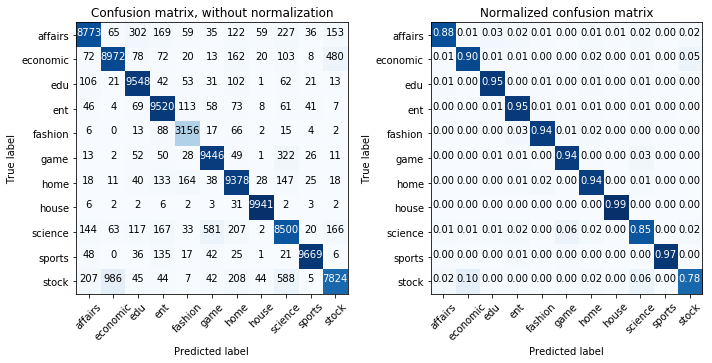

In [31]:
CLASSES_LIST = [cls.replace('\n', '') for cls in CLASSES_LIST]
class_names = np.unique(CLASSES_LIST)
conf_mat = confusion_matrix(y_test, y_predicted)
plt.figure(figsize=(10,10))
plt.subplot(121)
plot_confusion_matrix(conf_mat, class_names, title='Confusion matrix, without normalization')
plt.subplot(122)
plot_confusion_matrix(conf_mat, class_names, normalize=True, title='Normalized confusion matrix')
print(class_names)
print()